In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


In [20]:
train_dir = r"F:\work\python\archive\classification_task\train"
test_dir = r"F:\work\python\archive\classification_task\test"

In [21]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [22]:
import numpy as np

# Count images per class
class_counts = np.bincount(train_generator.classes)

# Get class names
class_labels = list(train_generator.class_indices.keys())

# Print results
for i, count in enumerate(class_counts):
    print(f"{class_labels[i]}: {count} images")

glioma: 1147 images
meningioma: 1329 images
no_tumor: 1067 images
pituitary: 1457 images


In [23]:
class_counts_test = np.bincount(val_generator.classes)
class_labels_test = list(val_generator.class_indices.keys())

for i, count in enumerate(class_counts_test):
    print(f"{class_labels_test[i]}: {count} images")

glioma: 254 images
meningioma: 306 images
no_tumor: 140 images
pituitary: 300 images


In [24]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [25]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=6,
    min_lr=1e-6
)


In [29]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.7124 - loss: 0.8278 - val_accuracy: 0.8020 - val_loss: 0.5113 - learning_rate: 1.0000e-04
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.8022 - loss: 0.5422 - val_accuracy: 0.8480 - val_loss: 0.4041 - learning_rate: 1.0000e-04
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.8362 - loss: 0.4693 - val_accuracy: 0.8550 - val_loss: 0.3602 - learning_rate: 1.0000e-04
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.8584 - loss: 0.3850 - val_accuracy: 0.8770 - val_loss: 0.3275 - learning_rate: 1.0000e-04
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.8740 - loss: 0.3458 - val_accuracy: 0.8820 - val_loss: 0.3040 - learning_rate: 1.0000e-04
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8752 - loss: 0.3480 - val_accuracy: 0.8840 - val_loss: 0.2822 - learning_rate: 1.0000e-04
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - acc

In [30]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 460s 3s/step - accuracy: 0.8934 - loss: 0.2832 - val_accuracy: 0.9150 - val_loss: 0.2309 - learning_rate: 1.0000e-05
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 408s 3s/step - accuracy: 0.9126 - loss: 0.2389 - val_accuracy: 0.9180 - val_loss: 0.2332 - learning_rate: 1.0000e-05
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 467s 3s/step - accuracy: 0.9190 - loss: 0.2154 - val_accuracy: 0.9310 - val_loss: 0.2008 - learning_rate: 1.0000e-05
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9316 - loss: 0.1872 - val_accuracy: 0.9330 - val_loss: 0.1788 - learning_rate: 1.0000e-05
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9350 - loss: 0.1670 - val_accuracy: 0.9410 - val_loss: 0.1560 - learning_rate: 1.0000e-05


In [31]:
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)

print(classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys()))

32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step
              precision    recall  f1-score   support

      glioma       0.95      0.89      0.92       254
  meningioma       0.91      0.92      0.91       306
    no_tumor       1.00      0.99      1.00       140
   pituitary       0.95      0.98      0.96       300

    accuracy                           0.94      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.94      0.94      0.94      1000



In [32]:
test_loss, test_accuracy = model.evaluate(val_generator, verbose=1)

print("Overall Testing Accuracy: {:.2f}%".format(test_accuracy * 100))

32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 947ms/step - accuracy: 0.9410 - loss: 0.1560
Overall Testing Accuracy: 94.10%


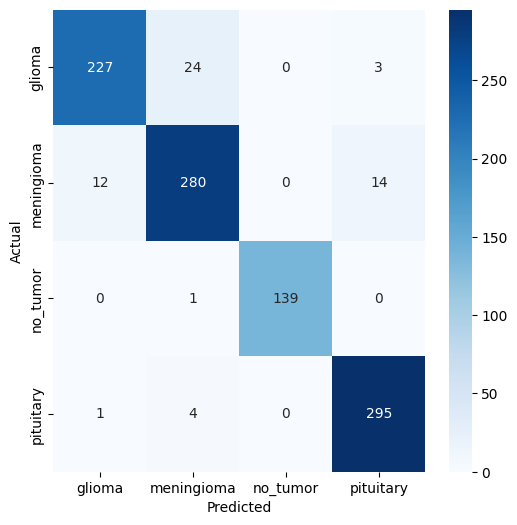

In [33]:
cm = confusion_matrix(val_generator.classes, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [34]:
print("Training samples:", train_generator.samples)
print("Testing samples:", val_generator.samples)


Training samples: 5000
Testing samples: 1000
